In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import gc
from glob import glob
import datetime
import random

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, make_scorer
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder


from catboost import CatBoostClassifier, Pool
from catboost.utils import get_fpr_curve, get_fnr_curve, get_roc_curve


# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

TRAIN = 'outflow_train_11w'

%matplotlib inline

C:\Users\pavel.pogozhy\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## sample

### CAMPAIGN

In [348]:
df_camp = result_to_df("""select * from (select t1.*, t2.rto, t2.fm, t2.cnt_trn from (
--select *  from (
select toInt64(crd_no) as ACCOUNT_ID, 
								c_start_date as C_START_DATE, 
								c_end_date as C_END_DATE,  
								cg  
								from communications
								where action_name like 'ottok%'
								and c_start_date > toDate('2020-09-01')
							) t1
--				left join (select LOYALTY_CARD_ID as CRD_NO, ACCOUNT_ID from DWHD.ACCOUNTS) t2
--				USING(ACCOUNT_ID) 
--               )  t1
left join (

select ACCOUNT_ID, C_START_DATE, C_END_DATE, cg, 
	round(sum(zsale_vat)) as rto, 
	round(sum(zsale_vat - zcst)) as fm, 
	sum(trn) as cnt_trn
	from (
		select * from (
								select toInt64(crd_no) as ACCOUNT_ID, 
								c_start_date as C_START_DATE, 
								c_end_date as C_END_DATE,  
								cg  
								from communications
								where action_name like 'ottok%'
								and c_start_date > toDate('2020-09-01')
							) t1
				left join (select LOYALTY_CARD_ID as CRD_NO, ACCOUNT_ID from DWHD.ACCOUNTS) t2
				USING(ACCOUNT_ID)
				) t1
left join (select zcustid as CRD_NO, zsale_vat, zcst, day_partitioned, 1 as trn from checks_headers_karusel chk 
			where day_partitioned >toDate('2020-09-01')
			) t2
USING(CRD_NO)
group by ACCOUNT_ID, C_START_DATE, C_END_DATE, cg
having (day_partitioned >= C_START_DATE and day_partitioned <= C_END_DATE) ) t2
USING(C_START_DATE, ACCOUNT_ID)) t1 
left join (select C_START_DATE, ACCOUNT_ID, 
	sumIf(ISS_POINTS, isFinite(ISS_POINTS)) as ISS_POINTS,
	sumIf(RED_POINTS, isFinite(RED_POINTS)) as RED_POINTS,	
	sumIf(TRANSACTION_DISCOUNT_AMT, isFinite(TRANSACTION_DISCOUNT_AMT)) as DISCOUNT_CAMP,
	sumIf(TRN_SECONDARY_POINTS_ISS, isFinite(TRN_SECONDARY_POINTS_ISS)) as SECONDARY_POINTS_ISS,
	sumIf(TRN_SECONDARY_POINTS_RED, isFinite(TRN_SECONDARY_POINTS_RED)) as SECONDARY_POINTS_RED
from (select TRANSACTION_DT, ACCOUNT_ID, ISS_POINTS, RED_POINTS, 
	TRANSACTION_DISCOUNT_AMT, TRN_SECONDARY_POINTS_ISS, TRN_SECONDARY_POINTS_RED 
	from DWHD.TRANSACTIONS t
	where TRANSACTION_DT > toDate('2020-09-01')) t1
	right join (select toInt64(crd_no) as ACCOUNT_ID, 
									c_start_date as C_START_DATE, 
									c_end_date as C_END_DATE  
									from communications
									where action_name like 'ottok%'
									and c_start_date > toDate('2020-09-01')) t2
	USING(ACCOUNT_ID)
	where TRANSACTION_DT >= C_START_DATE and TRANSACTION_DT <= C_END_DATE
	group by C_START_DATE, ACCOUNT_ID) t2
USING(C_START_DATE, ACCOUNT_ID)

""")
df_camp = df_camp.drop_duplicates()
df_camp = df_camp.drop_duplicates(['ACCOUNT_ID', 'C_START_DATE'])
df_camp['C_START_DATE'] = pd.to_datetime(df_camp['C_START_DATE'], format='%Y-%m-%d')
df_camp['ACCOUNT_ID'] = df_camp['ACCOUNT_ID'].astype(str)
df_camp['vis'] = 0
df_camp.loc[df_camp['cnt_trn']>0, 'vis'] = 1
df_camp.shape

(2720925, 13)

In [349]:
df_last_camp = df_camp[['ACCOUNT_ID', 'C_START_DATE', 'vis', 'RED_POINTS']].copy()
df_last_camp.columns = ['ACCOUNT_ID', 'C_START_DATE_last', 'vis_last', 'RED_POINTS_last']
df_last_camp = df_camp[['ACCOUNT_ID', 'C_START_DATE']].merge(df_last_camp, how='left', on='ACCOUNT_ID')
df_last_camp.head()

,ACCOUNT_ID,C_START_DATE,C_START_DATE_last,vis_last,RED_POINTS_last
0,21211051,2020-09-04,2020-09-04,0,0.0
1,23552760,2020-09-04,2020-09-04,0,0.0
2,82753845,2020-09-04,2020-09-04,0,0.0
3,82753845,2020-09-04,2020-10-02,0,0.0
4,67126431,2020-09-04,2020-09-04,0,0.0


In [350]:
df_last_camp = df_last_camp.loc[df_last_camp['C_START_DATE_last']<df_last_camp['C_START_DATE']
                ].groupby(['ACCOUNT_ID', 'C_START_DATE']).agg({'C_START_DATE_last':max, 'vis_last':sum, 
                                                               'RED_POINTS_last':[sum, max, np.count_nonzero]
                                                              }).reset_index()

In [351]:
df_last_camp.columns = ['ACCOUNT_ID', 'C_START_DATE', 'C_START_DATE_last', 'vis_sum',
                        'RED_POINTS_sum', 'RED_POINTS_max', 'RED_POINTS_cnt']
df_last_camp['last_camp'] = (df_last_camp['C_START_DATE']-df_last_camp['C_START_DATE_last']).dt.days
df_last_camp.head()

,ACCOUNT_ID,C_START_DATE,C_START_DATE_last,vis_sum,RED_POINTS_sum,RED_POINTS_max,RED_POINTS_cnt,last_camp
0,10927906,2020-09-18,2020-09-04,0,0.0,0.0,0.0,14
1,10927906,2020-10-02,2020-09-18,0,0.0,0.0,0.0,14
2,10927906,2020-10-30,2020-10-02,0,0.0,0.0,0.0,28
3,12305952,2020-09-18,2020-09-04,0,0.0,0.0,0.0,14
4,12305983,2020-09-25,2020-09-11,0,0.0,0.0,0.0,14


In [352]:
df_last_camp.loc[(df_last_camp.RED_POINTS_sum<0) & (df_last_camp.vis_sum==0)].head()

,ACCOUNT_ID,C_START_DATE,C_START_DATE_last,vis_sum,RED_POINTS_sum,RED_POINTS_max,RED_POINTS_cnt,last_camp
24255,12510223,2020-12-25,2020-10-09,0,-55.0,0.0,1.0,77
143812,14570190,2020-11-06,2020-10-02,0,-10.0,-10.0,1.0,35
158121,14755387,2020-11-27,2020-10-09,0,-16.0,0.0,1.0,49
158122,14755387,2020-12-11,2020-11-27,0,-16.0,0.0,1.0,14
238329,20942354,2020-12-11,2020-10-09,0,-6.0,0.0,1.0,63


In [353]:
df_last_camp.loc[(df_last_camp.RED_POINTS_sum<0) & (df_last_camp.vis_sum==0)].shape

(59, 8)

In [354]:
df_last_camp['C_START_DATE'] = pd.to_datetime(df_last_camp['C_START_DATE'], format='%Y-%m-%d')

In [355]:
df_camp = df_camp.merge(df_last_camp.drop('C_START_DATE_last', axis=1), how='left', on=['ACCOUNT_ID', 'C_START_DATE']).fillna(0)

In [357]:
df_camp.groupby(['C_START_DATE', 'cg']).size()

C_START_DATE  cg
2020-09-04    0     161310
              1      40370
2020-09-11    0     159774
              1      39986
2020-09-18    0     154624
              1      38694
2020-09-25    0     129918
              1      32591
2020-10-02    0     127578
              1      31973
2020-10-09    0     130414
              1      32670
2020-10-16    0     126597
              1      31845
2020-10-23    0      99283
              1      24210
2020-10-30    0     102353
              1      25038
2020-11-06    0      97591
              1      23828
2020-11-13    0      95329
              1      23366
2020-11-20    0      95520
              1      23103
2020-11-27    0      95182
              1      23137
2020-12-04    0     127520
              1      31930
2020-12-11    0     127988
              1      31988
2020-12-18    0     124040
              1      31033
2020-12-25    0     121038
              1      30274
2021-01-15    0     103052
              1      25778
dtype: int6

### datasets weekly

In [11]:
df_week = pd.DataFrame()
for f in glob(r'P:\Управление Бизнес-Аналитики\Отток\weekly\*'):
    buff = pd.read_csv(f, sep=';')
    df_week = pd.concat([df_week, buff], axis=0)

In [12]:
df_week = df_week.drop_duplicates()
df_week['CRD_NO'] = df_week['CRD_NO'].astype(str)
df_week.rename(columns={'BALANCE_BEF':'balance_bef', 'CRD_NO':'ACCOUNT_ID'}, inplace=True)
df_week['C_START_DATE'] = pd.to_datetime(df_week['C_START_DATE'], format='%Y-%m-%d').dt.date +pd.Timedelta(days=1)
df_week['MAX_DATE_BEF_CHURN'] = pd.to_datetime(df_week['MAX_DATE_BEF_CHURN'], format='%Y-%m-%d')
df_week = df_week.replace([-np.inf, np.inf], np.nan).dropna()
df_week.head()

,ACCOUNT_ID,C_START_DATE,MAX_DATE_BEF_CHURN,AVG_TICKET_LAST_CH,TEN_DAYS_SPEND_CH,M3_TICKET_CH,M3_TICKET_MIN,M3_TICKET_MAX,SALES_prev_churn,prev_churn_ind,balance_bef,REDEMP_RATE,days_bef_correct,fm_perc,promo_share,LIFETIME2,type_gm,filial_cfo,avg_discount,less_100_rub_share,zero_share,more5k_share,more2k_share,other_com,std,client_type,tickets_relation,traffic,repeats,client_type2,traffic_total,monthly_freq,NUM_COMS,RESP_RATE,have_mobapp_bef_com,price_score,Last_x5_purchase,X5_days_bef_com,mp_share,shops_in_X5
0,15360985,2020-12-18,2020-06-30,3194.38,3194.38,2510.312500,1700.88,3194.38,0.0,NOT_RESPONSED,7,-0.006374,165.0,0.129326,0.585230,5.0,vyletnoi,Центральный регион,0.049558,0.000000,0.0,0.025641,0.384615,0.0,872.519173,work_days,0.000000,4,3,more_than_one_repeat,45,2.500000,9,0.111111,1.0,0.247211,129.00,155.0,1.750000,1
1,23010559,2020-12-18,2020-07-01,3281.27,3848.01,1326.008889,58.99,3359.00,0.0,NOT_RESPONSED,26,0.000000,259.0,0.252329,0.284597,4.0,jiloy_massiv,Северо-западный реги,0.021324,0.062500,0.0,0.000000,0.187500,0.0,1884.932082,work_days,-0.784577,9,8,more_than_one_repeat,32,2.285714,7,0.714286,1.0,0.552093,434.94,1.0,0.111111,1
2,55069843,2020-12-18,2020-06-30,1777.81,1777.81,1329.211667,282.73,2247.95,0.0,NOT_RESPONSED,49,0.000000,317.0,0.282825,0.331925,2.0,jiloy_massiv,Северо-западный реги,0.027156,0.035714,0.0,0.000000,0.116071,0.0,631.505562,work_days,-0.811326,6,5,more_than_one_repeat,116,6.444444,13,0.000000,1.0,0.222252,0.00,999.0,12.166667,0
3,12324043,2020-12-18,2020-07-02,500.43,7403.66,807.307685,60.72,2523.89,0.0,NOT_RESPONSED,66,-0.007367,253.0,0.502588,0.060708,7.0,jiloy_massiv,Уральский регион,0.035096,0.025641,0.0,0.000000,0.034188,0.0,515.158929,work_days,-0.233595,107,106,more_than_one_repeat,116,19.333333,9,0.111111,1.0,0.435603,312.45,6.0,0.102804,1
4,82209678,2020-12-18,2020-06-30,768.39,768.39,297.672000,64.99,768.39,0.0,NOT_RESPONSED,4,0.000000,115.0,0.116217,0.509975,1.0,vyletnoi,Средне-Волжский реги,0.000000,0.367347,0.0,0.000000,0.000000,0.0,176.013608,work_days,0.556900,5,4,more_than_one_repeat,49,4.454545,6,0.333333,0.0,0.534787,391.97,6.0,8.400000,1


In [391]:
df_week.columns

Index(['ACCOUNT_ID', 'C_START_DATE', 'MAX_DATE_BEF_CHURN',
       'AVG_TICKET_LAST_CH', 'TEN_DAYS_SPEND_CH', 'M3_TICKET_CH',
       'M3_TICKET_MIN', 'M3_TICKET_MAX', 'SALES_prev_churn', 'prev_churn_ind',
       'balance_bef', 'REDEMP_RATE', 'days_bef_correct', 'fm_perc',
       'promo_share', 'LIFETIME2', 'type_gm', 'filial_cfo', 'avg_discount',
       'less_100_rub_share', 'zero_share', 'more5k_share', 'more2k_share',
       'other_com', 'std', 'client_type', 'tickets_relation', 'traffic',
       'repeats', 'client_type2', 'traffic_total', 'monthly_freq', 'NUM_COMS',
       'RESP_RATE', 'have_mobapp_bef_com', 'price_score', 'Last_x5_purchase',
       'X5_days_bef_com', 'mp_share', 'shops_in_X5'],
      dtype='object')

In [13]:
df_week.C_START_DATE.value_counts().sort_index()

2020-11-20    246070
2020-11-27    248601
2020-12-04    254080
2020-12-11    247019
2020-12-18    236361
2020-12-25    232473
2020-12-31    226034
2021-01-15    198958
Name: C_START_DATE, dtype: int64

### offers

In [14]:
offers = """select action_name, CRD_NO as ACCOUNT_ID, C_START_DATE, DISCOUNT, CG from USR_ATARASOV.communications
where action_name like 'ottok%'
and TO_DATE(C_START_DATE) > TO_DATE('2020-11-15', 'YYYY-MM-DD')"""
df_offers = query_select(offers, connection_sas)
df_offers = df_offers.drop_duplicates()
df_offers['ACCOUNT_ID'] = df_offers['ACCOUNT_ID'].astype(str)
df_offers['C_START_DATE'] = pd.to_datetime(df_offers['C_START_DATE'], format='%Y-%m-%d').dt.date
df_offers.C_START_DATE.value_counts().sort_index()

2020-11-20    118623
2020-11-27    118319
2020-12-04    159450
2020-12-11    160020
2020-12-18    155104
2020-12-25    151340
2021-01-15    128870
Name: C_START_DATE, dtype: int64

In [15]:
df_offers.groupby(['C_START_DATE', 'DISCOUNT', 'CG']).size()

C_START_DATE  DISCOUNT  CG
2020-11-20    0.0       1     23103
              50.0      0     20919
              100.0     0      2210
              150.0     0     48924
              200.0     0     23467
2020-11-27    0.0       1     23137
              50.0      0     21729
              100.0     0      2504
              150.0     0     46914
              200.0     0     24035
2020-12-04    50.0      0     37494
                        1      9559
              100.0     0     16353
                        1      4093
              150.0     0     49524
                        1     12287
              200.0     0     24149
                        1      5991
2020-12-11    50.0      0     40550
                        1      9991
              100.0     0     16651
                        1      4163
              150.0     0     47510
                        1     12040
              200.0     0     23277
                        1      5838
2020-12-18    50.0      0     35628
 

In [392]:
df_offers.head()

,ACTION_NAME,ACCOUNT_ID,C_START_DATE,DISCOUNT,CG
0,ottok_2011,13580472,2020-11-20,150.0,0
1,ottok_2011,14484683,2020-11-20,150.0,0
2,ottok_2011,27371407,2020-11-20,150.0,0
3,ottok_2011,57200307,2020-11-20,150.0,0
4,ottok_2011,22900954,2020-11-20,150.0,0


### merge

In [358]:
df_camp['C_START_DATE'] = pd.to_datetime(df_camp['C_START_DATE'], format='%Y-%m-%d').dt.date
df_all = df_week.merge(df_camp, how='left', on=['ACCOUNT_ID', 'C_START_DATE'])
df_all = df_all.merge(df_offers, how='left', on=['ACCOUNT_ID', 'C_START_DATE'])
df_all = df_all.loc[df_all.ACTION_NAME.isnull()==False]
df_all.loc[df_all['cg']==df_all['CG']]
df_all = df_all.drop_duplicates(subset=['C_START_DATE', 'ACCOUNT_ID'])
df_all['treat'] = 0
df_all.loc[df_all['cg']=='0', 'treat'] = 1
df_all.vis.value_counts()

0.0    848016
1.0    143567
Name: vis, dtype: int64

In [359]:
df_all.shape, df_all.drop_duplicates().shape

((991583, 60), (991583, 60))

In [360]:
df_all['MAX_DATE_BEF_CHURN'] = df_all['MAX_DATE_BEF_CHURN'].astype(str)
df_all['C_START_DATE'] = df_all['C_START_DATE'].astype(str)
df_all['C_END_DATE'] = df_all['C_END_DATE'].astype(str)

In [361]:
df_all['last_trn'] = (pd.to_datetime(df_all['C_START_DATE'], format='%Y-%m-%d')-pd.to_datetime(df_all['MAX_DATE_BEF_CHURN'], format='%Y-%m-%d')).dt.days
df_all['last_trn_100'] = 0
df_all.loc[df_all['last_trn']>100, 'last_trn_100'] = 1

In [395]:
df_all.loc[((df_all.RED_POINTS<0) & (df_all.vis==0))].shape

(61, 62)

In [364]:
df_all.shape

(991538, 62)

In [365]:
df_all.groupby(['C_START_DATE', 'DISCOUNT', 'CG']).size()

C_START_DATE  DISCOUNT  CG
2020-11-20    0.0       1     23103
              50.0      0     20919
              100.0     0      2210
              150.0     0     48922
              200.0     0     23467
2020-11-27    0.0       1     23134
              50.0      0     21726
              100.0     0      2503
              150.0     0     46914
              200.0     0     24035
2020-12-04    50.0      0     37490
                        1      9558
              100.0     0     16352
                        1      4093
              150.0     0     49523
                        1     12286
              200.0     0     24149
                        1      5991
2020-12-11    50.0      0     40542
                        1      9979
              100.0     0     16649
                        1      4160
              150.0     0     47505
                        1     12028
              200.0     0     23274
                        1      5829
2020-12-18    50.0      0     35620
 

In [21]:
sorted(df_all.C_START_DATE.unique())

['2020-11-20',
 '2020-11-27',
 '2020-12-04',
 '2020-12-11',
 '2020-12-18',
 '2020-12-25',
 '2021-01-15']

### train&test

In [366]:
train_date = sorted(df_all.C_START_DATE.unique())[2:-2]
test_date = sorted(df_all.C_START_DATE.unique())[-2]
train_date, test_date

(['2020-12-04', '2020-12-11', '2020-12-18'], '2020-12-25')

In [367]:
feature_col = [
#         'C_START_DATE', 'MAX_DATE_BEF_CHURN',
       'AVG_TICKET_LAST_CH', 'TEN_DAYS_SPEND_CH', 'M3_TICKET_CH',
       'M3_TICKET_MIN', 'M3_TICKET_MAX', 'SALES_prev_churn', 'prev_churn_ind',
       'balance_bef', 'REDEMP_RATE', 'days_bef_correct', 'fm_perc',
       'promo_share', 'LIFETIME2', 'type_gm', 'filial_cfo', 'avg_discount',
       'less_100_rub_share', 'zero_share', 'more5k_share', 'more2k_share',
       'other_com', 'std', 'client_type', 'tickets_relation', 'traffic',
       'repeats', 'client_type2', 'traffic_total', 'monthly_freq', 'NUM_COMS',
       'RESP_RATE', 'have_mobapp_bef_com', 'price_score', 'Last_x5_purchase',
       'X5_days_bef_com', 'mp_share', 'shops_in_X5', 'last_trn', 'last_trn_100', 'vis_sum',
       'RED_POINTS_sum', 'RED_POINTS_max', 'RED_POINTS_cnt', 'last_camp'
#     ,'C_END_DATE'
]

In [368]:
X_train = df_all.loc[df_all.C_START_DATE.isin(train_date)][feature_col].copy()
X_test = df_all.loc[df_all.C_START_DATE==test_date][feature_col].copy()

train_crd = df_all.loc[df_all.C_START_DATE.isin(train_date)]['ACCOUNT_ID']
test_crd = df_all.loc[df_all.C_START_DATE==test_date]['ACCOUNT_ID']

offer_train = df_all.loc[df_all.C_START_DATE.isin(train_date)]['DISCOUNT']
offer_test = df_all.loc[df_all.C_START_DATE==test_date]['DISCOUNT'] 

treat_train = df_all.loc[df_all.C_START_DATE.isin(train_date)]['treat']
treat_test = df_all.loc[df_all.C_START_DATE==test_date]['treat']

y_train = df_all.loc[df_all.C_START_DATE.isin(train_date)]['vis']
y_test = df_all.loc[df_all.C_START_DATE==test_date]['vis']

In [26]:
df_all.loc[df_all.C_START_DATE.isin(train_date)
                       ].groupby(['C_START_DATE','cg'])['DISCOUNT'].value_counts(normalize=True)

C_START_DATE  cg  DISCOUNT
2020-12-04    0   150.0       0.388363
                  50.0        0.294024
                  200.0       0.189374
                  100.0       0.128239
              1   150.0       0.384811
                  50.0        0.299374
                  200.0       0.187629
                  100.0       0.128187
2020-12-11    0   150.0       0.371207
                  50.0        0.316827
                  200.0       0.181869
                  100.0       0.130098
              1   150.0       0.375953
                  50.0        0.311929
                  200.0       0.182131
                  100.0       0.129986
2020-12-18    0   150.0       0.393736
                  50.0        0.287230
                  200.0       0.189528
                  100.0       0.129507
              1   150.0       0.396578
                  50.0        0.287146
                  200.0       0.186994
                  100.0       0.129282
Name: DISCOUNT, dtype: float64

In [27]:
df_all.loc[df_all.C_START_DATE==test_date
                       ].groupby(['cg'])['DISCOUNT'].value_counts(normalize=True)

cg  DISCOUNT
0   150.0       0.398040
    50.0        0.285084
    200.0       0.182050
    100.0       0.134825
1   150.0       0.398461
    50.0        0.286252
    200.0       0.182070
    100.0       0.133217
Name: DISCOUNT, dtype: float64

## uplift

In [28]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [29]:
categ = [X_train.columns.get_loc(c) for c in X_train.select_dtypes(include='object').columns]
categ

[6, 13, 14, 22, 26]

In [30]:
treat_train.value_counts(normalize=True)

1    0.799892
0    0.200108
Name: treat, dtype: float64

In [31]:
treat_test.value_counts(normalize=True)

1    0.799923
0    0.200077
Name: treat, dtype: float64

### solo

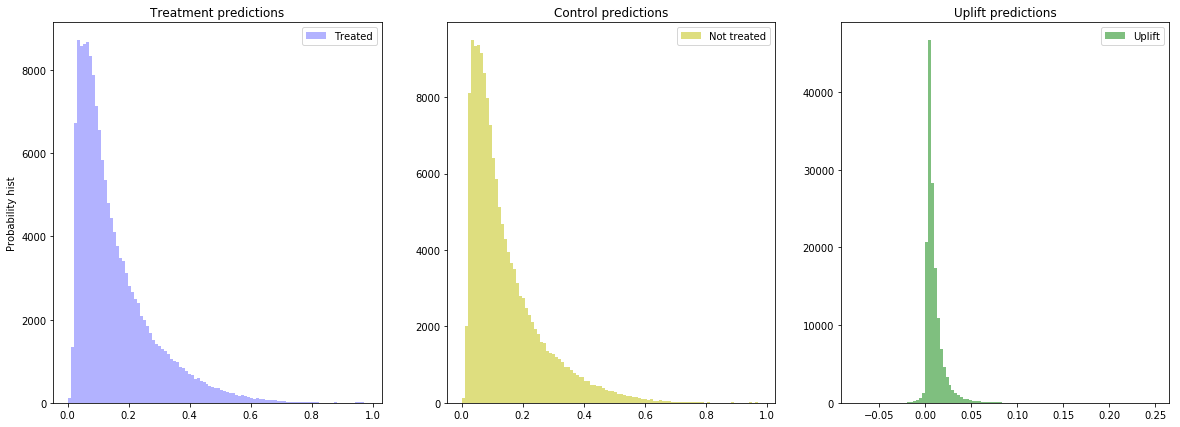

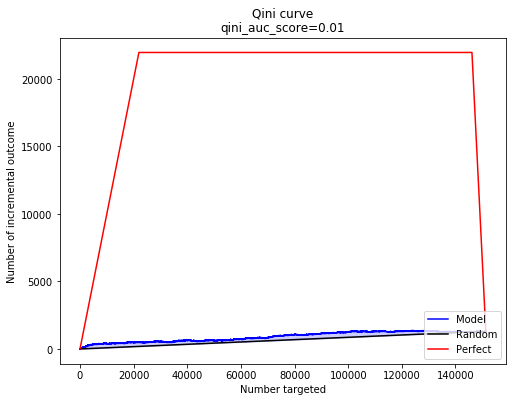

In [32]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklift1.metrics import uplift_at_k
from sklift1.viz import plot_uplift_preds, plot_qini_curve
from sklift1.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier, CatBoostRegressor

sm = SoloModel(CatBoostClassifier(thread_count=2
                                  , random_state=42
                                  , silent=True
                                  , task_type="GPU"
                                  , devices='0:1'
                                 ))

sm = sm.fit(X_train, y_train, treat_train
            , estimator_fit_params={'cat_features': categ}
           )


uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

plot_qini_curve(y_true=y_test, uplift=uplift_sm, treatment=treat_test)

In [33]:
models_results

{'approach': ['SoloModel'], 'uplift@30%': [0.01603820456558791]}

### class transform

In [35]:
p_train = y_train.loc[treat_train==1].shape[0]/y_train.shape[0]
p_test = y_test.loc[treat_test==1].shape[0]/y_test.shape[0]
p_train = 0.5
p_test=0.5
p_train, p_test

(0.5, 0.5)

In [42]:
z_train = y_train*(treat_train-p_train)/(p_train*(1-p_train))
z_test = y_test*(treat_test-p_test)/(p_test*(1-p_test))

In [43]:
z_train.value_counts()

-0.0    401873
 2.0     58889
-2.0     13737
dtype: int64

In [44]:
z_train = (treat_train==y_train).astype(int)
z_test = (treat_test==y_test).astype(int)

In [45]:
z_train.value_counts()

0    334396
1    140103
dtype: int64

#### balance optimal offer classifier

0.011819720254052535
0.0173394585888354
0.013747768481090883
0.010021317407266334


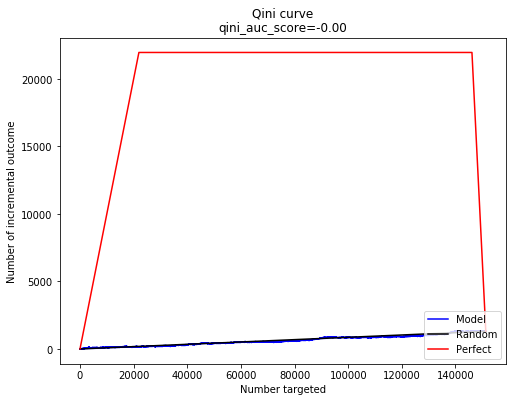

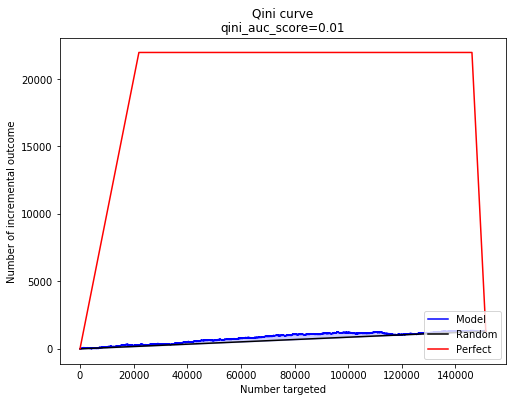

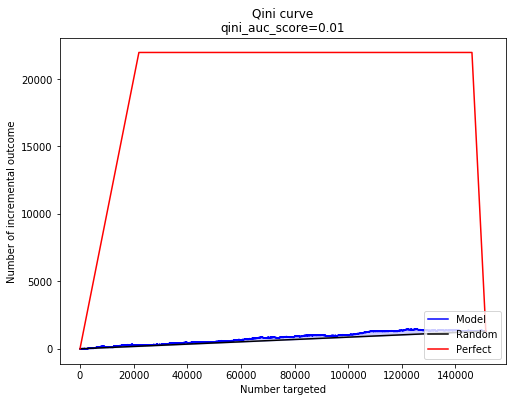

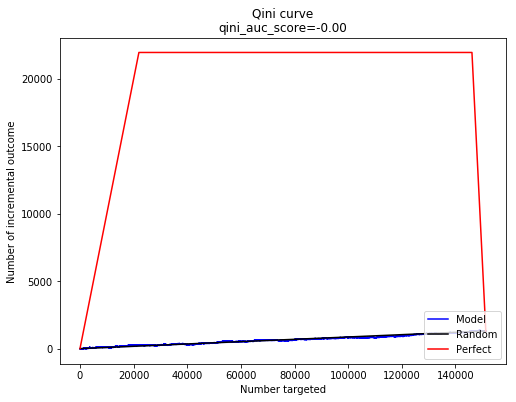

In [47]:
from sklift1.models import ClassTransformation
from sklift1.viz import plot_uplift_preds, plot_qini_curve
from sklift1.metrics import uplift_at_k
from catboost import CatBoostClassifier

# Так как подход требует, чтобы доля объектов тестовой группы
# равнялась доле объектов контрольной группы, воспользуемся
# встроенной функцией, уравнивающей группы
# (Возвращает np.array)

ct = ClassTransformation(CatBoostClassifier(
                                thread_count=2
                              , eval_metric='AUC'
                              , loss_function= 'Logloss'
                              , random_state=43
                              , silent=True
                              , depth = 4
                              , iterations=1000
                              , learning_rate=0.05
                              , task_type="GPU"
                              , devices='0:1'
                              , custom_loss=['Precision', 'Recall'] 
                                           )
                        )                
uplift_df = pd.DataFrame()                        
for treat in offer_train.unique():
    treat_shape = X_train.loc[(offer_train==treat) & (treat_train==1)].index
    cg_shape = X_train.loc[(offer_train==treat) & (treat_train==0)].index
    if len(cg_shape) > len(treat_shape):    
        y_train_balance = pd.concat([y_train.loc[treat_shape], y_train.loc[cg_shape].sample(n=len(treat_shape))], axis=0)
        X_train_balance = X_train.loc[y_train_balance.index]
        treat_train_balance = treat_train.loc[y_train_balance.index]
    else:
        y_train_balance = pd.concat([y_train.loc[treat_shape].sample(n=len(cg_shape)), y_train.loc[cg_shape]], axis=0)
        X_train_balance = X_train.loc[y_train_balance.index]
        treat_train_balance = treat_train.loc[y_train_balance.index]
        
            
    ct = ct.fit(X_train_balance, y_train_balance, treat_train_balance,
                estimator_fit_params={'cat_features': categ,
                                      'plot':False})

    uplift_ct = pd.Series(2 * ct.estimator.predict_proba(X_test)[:, 1] - 1, name=str(treat))
    uplift_df = pd.concat([uplift_df, uplift_ct], axis=1)
    ct_score =  uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)
    print(ct_score)

#     models_results['approach'].append('ClassTransformation')
#     models_results['uplift@30%'].append(ct_score)

    plot_qini_curve(y_true=y_test, uplift=uplift_ct, treatment=treat_test);

In [48]:
uplift_df.head()

,200.0,50.0,150.0,100.0
0,0.086918,0.083581,0.131467,0.152470
1,0.027765,0.019766,0.144092,-0.012471
2,0.023595,-0.118645,-0.115086,0.010560
3,0.001719,0.132692,0.027531,0.021891
4,-0.589675,0.135587,-0.036035,0.132662


In [49]:
up_max = uplift_df.idxmax(axis=1).astype(float).astype(int)
up_max.value_counts()

200    44833
100    40755
50     34500
150    31224
dtype: int64

In [50]:
offer_test.value_counts()

150.0    60241
50.0     43172
200.0    27547
100.0    20352
Name: DISCOUNT, dtype: int64

In [51]:
y_test.shape

(151312,)

In [52]:
sum(offer_test.values == up_max.values)

30441

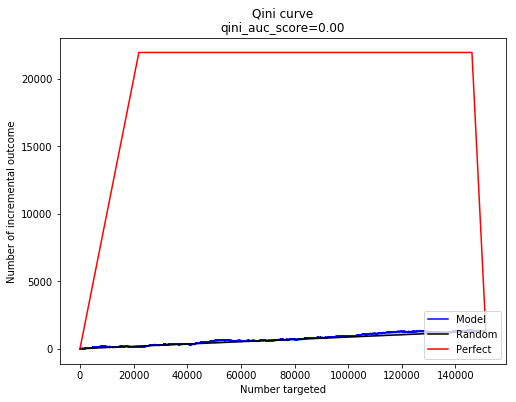

In [53]:
plot_qini_curve(y_true=y_test, uplift=uplift_df.max(axis=1), treatment=treat_test);

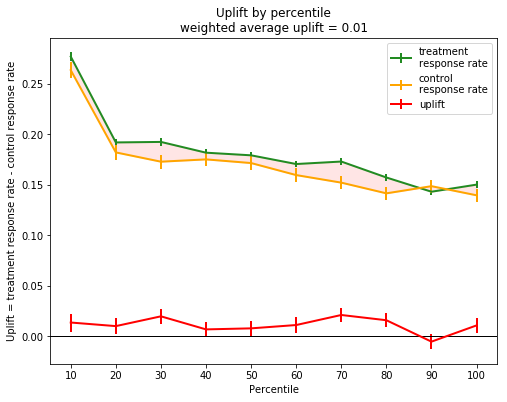

In [54]:
from sklift1.viz import plot_uplift_by_percentile
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_df.max(axis=1)
                          , treatment=treat_test, strategy='overall', kind='line', bins=10);

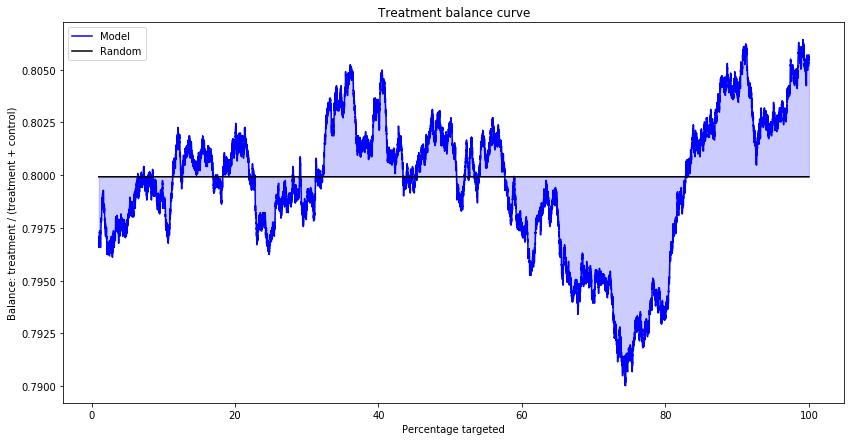

In [55]:
from sklift1.viz import plot_treatment_balance_curve
plot_treatment_balance_curve(uplift=uplift_df.max(axis=1), treatment=treat_test, random=True, winsize=0.1);

#### regression fm

In [369]:
y_train_fm = df_all.loc[df_all.C_START_DATE.isin(train_date)]['fm']
y_test_fm = df_all.loc[df_all.C_START_DATE==test_date]['fm']

z_train = y_train_fm*(treat_train-0.5)/(0.5*(1-0.5))
z_test = y_test_fm*(treat_test-0.5)/(0.5*(1-0.5))

In [370]:
from sklift1.models import ClassTransformation
from sklift1.viz import plot_uplift_preds, plot_qini_curve
from sklift1.metrics import uplift_at_k

from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import KFold

try:
    del uplift_ct
except: pass

uplift_df = pd.DataFrame()                        
for treat in offer_train.unique():
    treat_shape = X_train.loc[(offer_train==treat) & (treat_train==1)].index
    cg_shape = X_train.loc[(offer_train==treat) & (treat_train==0)].index
    if len(cg_shape) > len(treat_shape):    
        y_train_balance = pd.concat([y_train_fm.loc[treat_shape], y_train_fm.loc[cg_shape].sample(n=len(treat_shape))], axis=0)
        z_train_balance = z_train.loc[y_train_balance.index]
        X_train_balance = X_train.loc[y_train_balance.index]
        treat_train_balance = treat_train.loc[y_train_balance.index]
    else:
        y_train_balance = pd.concat([y_train_fm.loc[treat_shape].sample(n=len(cg_shape)), y_train_fm.loc[cg_shape]], axis=0)
        z_train_balance = z_train.loc[y_train_balance.index]
        X_train_balance = X_train.loc[y_train_balance.index]
        treat_train_balance = treat_train.loc[y_train_balance.index]
        
    ct_score_mean = []
    ct_score_std = []

    for seed in [44, 77, 88, 42, 0]:
        ct_reg = CatBoostRegressor(thread_count=2
                                  , random_state=seed
                                  , silent=True
                                  , task_type="GPU"
                                  , devices='0:1'
                                  , loss_function='RMSE'
                                  , iterations=500
                                  , learning_rate=0.1
                                  , depth=2
                                 )    
        
        ct_reg.fit(X_train_balance, z_train_balance,
                    cat_features=categ,
                    plot=False)
        try:
            uplift_ct = np.concatenate((uplift_ct, ct_reg.predict(X_test).reshape(-1,1)), axis=1)
        except: 
            uplift_ct = ct_reg.predict(X_test).reshape(-1, 1)
#         print(uplift_ct.shape)
    
    mean_offer_predicts = np.mean(uplift_ct,axis=1) 
          
    up_sort = np.sort(mean_offer_predicts)[::-1]

    perc = 0.8

    up_treat_1 = up_sort[treat_test==1][:int(len(up_sort[treat_test==1])*perc)].sum()
    up_treat_0 = up_sort[treat_test==0][:int(len(up_sort[treat_test==0])*perc)].sum()
    upl = up_treat_1 - up_treat_0

    ct_score_mean.append(np.mean(uplift_ct))
    ct_score_std.append(np.std(uplift_ct))
        
    uplift_ct = pd.Series(mean_offer_predicts, name=str(treat))
    uplift_df = pd.concat([uplift_df, uplift_ct], axis=1)

    print(treat,upl, ct_score_mean, ct_score_std)

200.0 1302566.1722764396 [-76.84387424162122] [393.7774421904857]
50.0 762286.2824914182 [-2.6229739314719254] [100.7279761127649]
150.0 322929.35886663443 [-6.858219517465068] [116.31963444430076]
100.0 1561953.3470472791 [-1.3330486814696365] [142.7145244929316]


In [371]:
up_max = uplift_df.idxmax(axis=1).astype(float).astype(int)
up_max.value_counts()

200    52655
100    40359
50     38976
150    19311
dtype: int64

In [372]:
uplift_df.head()

,200.0,50.0,150.0,100.0
0,9.899034,-612.984778,284.334109,399.259537
1,-2.957708,0.277428,-2.331658,-4.176845
2,1.307290,-8.602447,-9.102929,-1.215937
3,19.981096,-3.078759,-10.456431,-0.835964
4,16.360938,-4.435680,-0.792839,-2.257392


In [373]:
sum(offer_test.values == up_max.values)

25247

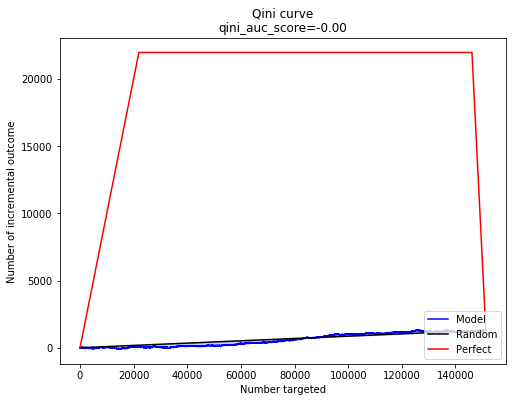

In [374]:
plot_qini_curve(y_true=y_test, uplift=uplift_df.max(axis=1), treatment=treat_test);

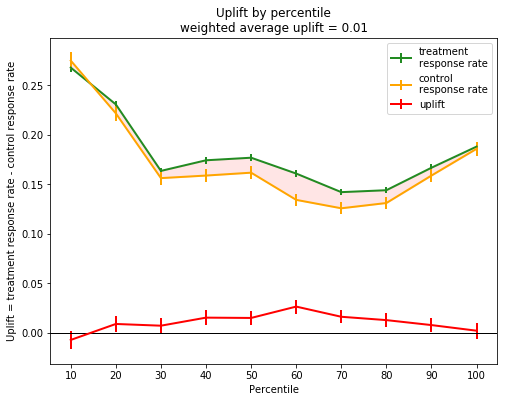

In [375]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_df.max(axis=1)
                          , treatment=treat_test, strategy='overall', kind='line', bins=10);

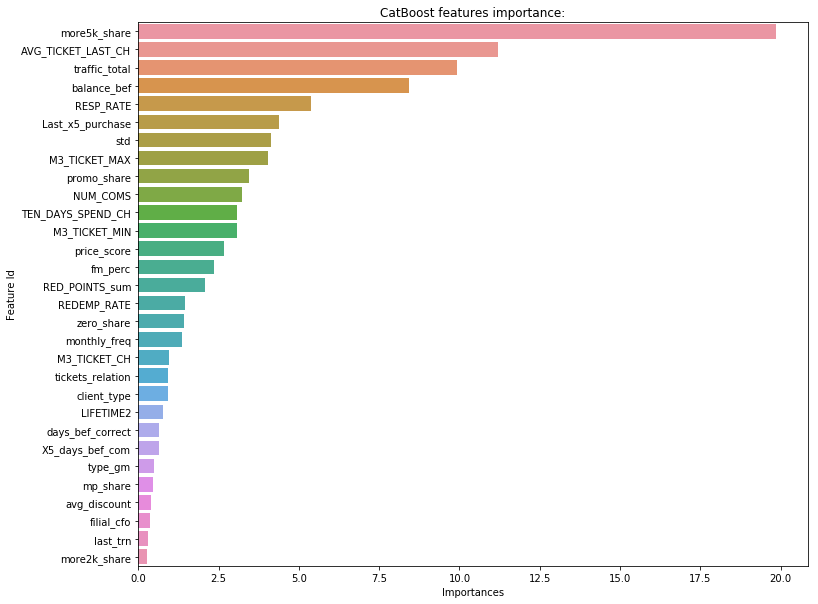

In [376]:
feature_importance_df = ct_reg.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df.head(30));
plt.title('CatBoost features importance:');

#### check fm equal

In [377]:
uplift_df.shape, y_test.shape

((151301, 4), (151301,))

In [399]:
up_max_df = uplift_df.max(axis=1).to_frame()
up_max_df['ind'] = y_test.index.to_list()
up_max_df['offer_new'] = uplift_df.idxmax(axis=1).astype(float).astype(int)
up_max_df['offer_old'] = offer_test[up_max_df['ind']].values
up_max_df['fm_fact'] = y_test_fm[up_max_df['ind']].values
up_max_df['redemp'] = df_all.loc[y_test[up_max_df['ind']].index, 'RED_POINTS'].values
up_max_df['fm_new_off'] = up_max_df['fm_fact']
up_max_df.loc[(np.abs(up_max_df.redemp)>=up_max_df['offer_old']) 
              & (up_max_df['offer_new']>up_max_df['offer_old'])
              , 'fm_new_off'] = up_max_df['fm_fact'] - up_max_df['offer_old'] +up_max_df['offer_new']
up_max_df.loc[(np.abs(up_max_df.redemp)>=up_max_df['offer_old']) 
              & (up_max_df['offer_new']<up_max_df['offer_old'])
              , 'fm_new_off'] = up_max_df['fm_fact'] - up_max_df['offer_old'] +up_max_df['offer_new']
up_max_df['visit_fact'] = y_test[up_max_df['ind']].values
up_max_df = up_max_df.sort_values(0, ascending=False)

In [409]:
up_max_df.head()

,0,ind,offer_new,offer_old,fm_fact,redemp,fm_new_off,visit_fact
23773,8755.173999,1200743,150,150.0,0.0,0.0,0.0,0.0
118592,7772.394942,1346140,150,100.0,0.0,0.0,0.0,0.0
38941,7628.470493,1224149,150,200.0,0.0,0.0,0.0,0.0
77337,7161.638648,1282951,50,150.0,-1685.0,-198.0,-1785.0,1.0
95129,7124.255403,1310161,150,200.0,0.0,0.0,0.0,0.0


In [406]:
sum(up_max_df['offer_new'] ==up_max_df['offer_old'])

25247

In [411]:
up_max_df.head(100_000)['fm_fact'].mean(), up_max_df.tail(50_000)['fm_fact'].mean()

(113.01342, 70.30854)

In [412]:
up_max_df.head(100_000)['fm_new_off'].mean(), up_max_df.tail(50_000)['fm_new_off'].mean()

(113.50192, 70.41054)

In [417]:
n = 50000
y_test_fm[y_test!=0].head(n).sum()

14892364.0

In [434]:
fm_default = up_max_df[up_max_df.visit_fact!=0]['fm_fact'].head(n).sum()
fm_default

14892364.0

In [435]:
fm_new = up_max_df[up_max_df.visit_fact!=0]['fm_new_off'].head(n).sum()
fm_new

14946164.0

In [436]:
fm_new-fm_default

53800.0